# Rotated pole coordinate transform


Three parameters define a general latitude/longitude coordinate system, formed
by a general rotation of the sphere. One choice for these parameters is the one considered in CF:

```
grid_mapping_name = rotated_latitude_longitude

Map parameters:

        grid_north_pole_latitude

        grid_north_pole_longitude

        north_pole_grid_longitude - This parameter is optional (default is 0).

Map coordinates:

    The rotated latitude and longitude coordinates are identified by the
    standard_name attribute values grid_latitude and grid_longitude
    respectively.
```


Grid Mapping Attributes

| Attribute | Description |
|---|---
| grid_mapping_name         | The name used to identify the grid mapping.                          |
| grid_north_pole_latitude  | True latitude (degrees_north) of the north pole of the rotated grid. |
| grid_north_pole_longitude | True longitude (degrees_east) of the north pole of the rotated grid. |
| north_pole_grid_longitude | Longitude (degrees) of the true north pole in the rotated grid.      |

As described, there is an ambiguity, since there are two ways to reach the same north pole position.
For instance, (long 190, lat 30) can be reached both by: 

  1. rotating 10 degrees around the Z axis and then doing a rotation of -60 degrees around the new Y axis;
  2. rotating 190 degrees around the Z axis and the doing a rotation of +60 degrees around the new Y axis.
  
Again, (long -169.5, lat 46.5): (yes, it would be the same of declaring a long of +190.5

  1. rotating +10.5 degrees around the Z axis and then doing a rotation of -33.5 degrees around the new Y axis
  2. rotating -169.5 degrees around the Z axis and then doing a rotation of +33.5 degrees around the new Y axis.

Again, (long 45.3, lat -34): 
  
  1. rotating 45.3 degrees around the Z axis and then doing a rotation of + (90 + 34) degrees around the new Y axis
  2. rotating (45.3 + 180) degrees around the Z axis and then doing a rotation of + (180 - 34) around the new Y axis

A way to fix this is to constrain the first rotation between -90, +90. Then only the first option will be avaliable.
  
The following is an implementation of this coordinate transform.

In [1]:
from math import pi
import numpy as np

def lonlat(np_true_long, np_true_lat, lonp, latp):
    """Map latp and lonp in the rotated pole coordinates to standard lat and lon
       np_true_lat is the true latitude of the north pole of the new coord system
       np_true_long   is the true longitude of the north pole of the new coord system
    """
    # we assume that the transform was first a rotation on the Z and then a rotation on the long=0 circle 
    np_true_long = np_true_long % 360
    if abs(np_true_long) > 90:
        phi = np_true_long - 180
        theta = -(90 - np_true_lat)
    else:
        phi = np_true_long
        theta = 90 - np_true_lat
    # phi is how much we, first, rotated around the Z axis
    # theta is how much we then rotated around the new Y axis
    theta = pi * (theta/180)
    phi = pi * (phi/180)
    latp = pi * latp/180
    lonp = pi * lonp/180
    lat = np.arcsin(np.cos(theta) * np.sin(latp) - np.cos(lonp) * np.sin(theta) * np.cos(latp))
    lon = np.arctan2(np.sin(lonp), np.tan(latp) * np.sin(theta) + np.cos(lonp) * np.cos(theta)) + phi
    return 180 * lon / pi, 180 * lat/pi

## Example: tdm moloch simulations

The moloch/bolam data come as grib2 files. The data is arranged on a rotated pole coordinated system, but this time it is expressed in terms of the position of the southern pole.

From the grib2 documentation:

Three parameters define a general latitude/longitude coordinate system, formed
by a general rotation of the sphere. One choice for these parameters is:

  (a) The geographic latitude in degrees of the southern pole of the coordinate
  system, $\theta_p$  for example.

  (b) The geographic longitude in degrees of the southern pole of the coordinate
  system, $\lambda_p$ for example.

  (c) The angle of rotation in degrees about the new polar axis (measured
  **clockwise** when looking from the southern to the northern pole) of the
  coordinate system, assuming the new axis to have been obtained by first
  rotating the sphere through $\lambda_p$ degrees about the geographic polar axis and
  then rotating through (90 + $\theta_p$) degrees so that the southern pole moved along
  the (previously rotated) Greenwich meridian.

We will now consider a specific dataset and extract grid information

In [2]:
!wgrib2 -d 1 -grid ./data/moloch_2018050103_0011800.grib2

/bin/sh: 1: wgrib2: not found


In [5]:
sp_lon, sp_lat =  10.5, -46.5
np_lon, np_lat = sp_lon - 180, -sp_lat # 
np_lon, np_lat

(-169.5, 46.5)

In [6]:
rlon = np.arange(354.9 - 360, 7.917601, 0.0226)
rlat = np.arange(-8.0886, 5.044200 + 0.0228, 0.0228)

We can now use `wgrib2` to get the *real* lon, lat coordinates of the grid points

In [7]:
! wgrib2 -d 1 -grid  ./data/moloch_2018050103_0011800.grib2 -csv tlatlon.csv

/bin/sh: 1: wgrib2: not found


In [9]:
from csv import DictReader
#2018-05-01 03:00:00","2018-05-02 13:00:00","TMP","950 mb",4.56119,35.2367,290.238
c = DictReader(open('./data/tlatlon.csv'), fieldnames=['t1', 't2', 'vname', 'vname2', 'lon', 'lat', 'value'])
tlon, tlat = [_ for _ in zip(*((float(r['lon']), float(r['lat'])) for r in c))]
tlon = np.array(tlon).reshape(577, 577)
tlat = np.array(tlat).reshape(577, 577)

In [10]:
tlon[0,0], tlat[0,0], lonlat(np_lon, np_lat, rlon[0], rlat[0])

(4.3153300000000003,
 35.222000000000001,
 (4.3153314373802294, 35.221948801352468))

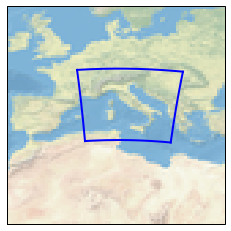

In [11]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
ax.set_extent((-10, 30, 20, 60), crs=ccrs.PlateCarree())

left = lonlat(np_lon, np_lat, rlon.min(), rlat)
right = lonlat(np_lon, np_lat, rlon.max(), rlat)
bottom = lonlat(np_lon, np_lat, rlon, rlat.min())
top = lonlat(np_lon, np_lat, rlon, rlat.max())
for side in [bottom, left, top, right]:
    plt.plot(side[0], side[1],
             color='blue', linewidth=2, ## marker='o',
             transform=ccrs.PlateCarree(),
             )
plt.show()